# Sentiment Classification: Deep Learning (LSTM) Approach
This notebook demonstrates sentiment classification using a deep learning model (LSTM) with Keras.

**Approach:**
- Load and clean text data (lowercase, remove HTML, numbers, punctuation, stopwords).
- Tokenize and pad text sequences for LSTM input.
- Encode labels and convert to one-hot vectors.
- Build and train a Bidirectional LSTM model (with hyperparameter tuning).
- Evaluate using accuracy, precision, recall, F1-score, and confusion matrix.
- Save the trained model, tokenizer, and encoder for future use.

**Assumptions:**
- Input CSVs have at least two columns: text and label (notebook will rename if needed).
- Data is already split into train and test sets via CSVs.
- Labels are binary (0/1 or negative/positive).
- NLTK stopwords are downloaded at runtime if not present.
- For larger datasets, increase epochs and tune hyperparameters as needed.

In [ ]:
# Install TensorFlow
%pip install tensorflow

In [ ]:
# Import all required libraries for data loading, preprocessing, deep learning (TensorFlow/Keras), evaluation, & saving models
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [3]:
# Load your training and test data from the Data folder
train_path = os.path.join('..', 'Data', 'train_data.csv')
test_path = os.path.join('..', 'Data', 'test_data.csv')

In [4]:
# Load the training and test CSVs into pandas DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
# Text cleaning: lowercase, remove HTML, numbers, punctuation, and stopwords
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

In [6]:
# Ensure correct columns for both datasets before cleaning
for df, name in zip([train_df, test_df], ['train', 'test']):
    cols = list(df.columns)
    if 'text' not in cols or 'label' not in cols:
        print(f"{name} columns found: {cols}")
        if len(cols) >= 2:
            df.rename(columns={cols[0]: 'text', cols[1]: 'label'}, inplace=True)
        else:
            raise ValueError(f"{name} CSV must have at least two columns for text and label.")

train columns found: ['0', '1']
test columns found: ['0', '1']


In [7]:
# Clean text in both train and test DataFrames (they're already split via CSVs)
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text']  = test_df['text'].apply(clean_text)

# Preview a few rows to confirm cleaning worked
train_df[['clean_text','label']].head(), test_df[['clean_text','label']].head()

(                                          clean_text  label
 0  film absolutely awful nevertheless hilarious t...      0
 1  well since seeing parts honestly say never mad...      0
 2  got see film preview dazzled typical romantic ...      1
 3  adaptation positively butchers classic beloved...      0
 4  råzone awful movie simple seems tried make mov...      0,
                                           clean_text  label
 0  enjoy film eraser whatsoever awful acting bori...      0
 1  afraid anyone likes film probably inhaled many...      0
 2  rd last big screen spin popular itv sitcom ear...      0
 3  barely three half years scraping months run oc...      1
 4  im big fan demonic puppets looking surface one...      0)

In [8]:
# Set the vocabulary size and sequence length for our tokenizer and padding
max_words = 20000
maxlen = 200

In [9]:
# Convert text to padded sequences for the LSTM model
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_seq  = tokenizer.texts_to_sequences(test_df['clean_text'])
X_train = keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test  = keras.preprocessing.sequence.pad_sequences(X_test_seq,  maxlen=maxlen, padding='post', truncating='post')

In [10]:
# Encode the labels as integers and one-hot vectors for training
le = LabelEncoder()
y_train = le.fit_transform(train_df['label'])
y_test  = le.transform(test_df['label'])
num_classes = len(le.classes_)
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat  = keras.utils.to_categorical(y_test,  num_classes)

In [ ]:
# Build a simple LSTM model for text classification
embedding_dim = 128
model = keras.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen),
    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [21]:
# Compile and train the LSTM model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, validation_split=0.1, epochs=5, batch_size=64)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 232s 639ms/step - accuracy: 0.7959 - loss: 0.4427 - val_accuracy: 0.8680 - val_loss: 0.3319
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 256s 621ms/step - accuracy: 0.9004 - loss: 0.2613 - val_accuracy: 0.8668 - val_loss: 0.3423
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 217s 616ms/step - accuracy: 0.9360 - loss: 0.1799 - val_accuracy: 0.8596 - val_loss: 0.4228
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 216s 614ms/step - accuracy: 0.9519 - loss: 0.1390 - val_accuracy: 0.8624 - val_loss: 0.4232
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 262s 614ms/step - accuracy: 0.9671 - loss: 0.0947 - val_accuracy: 0.8412 - val_loss: 0.5126


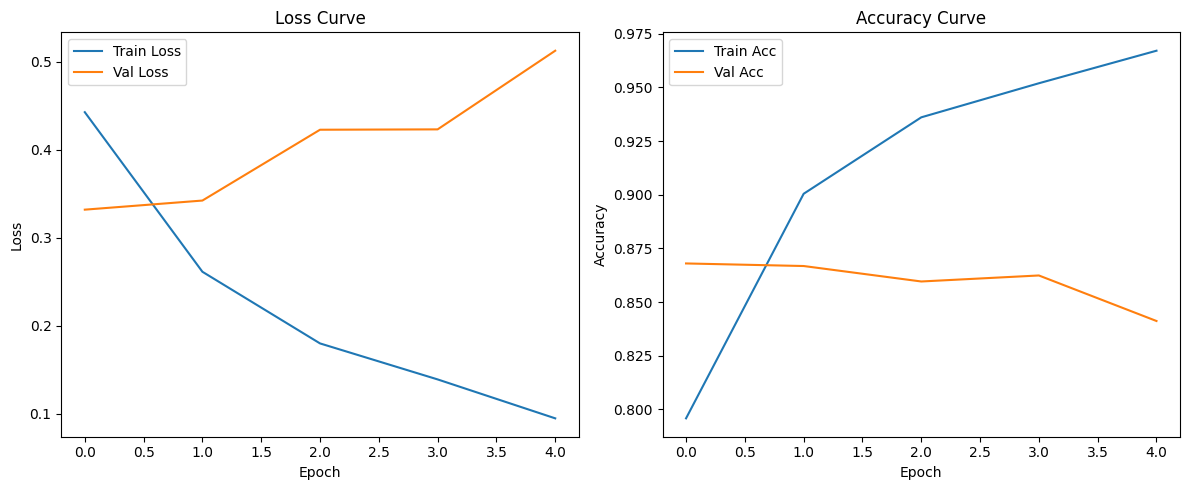

In [22]:
# Plot training and validation loss and accuracy curves to visualize overfitting/underfitting
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Hyperparameter tuning: Try different values for embedding_dim, LSTM units, and batch size
from tensorflow.keras.callbacks import EarlyStopping

embedding_dims = [64, 128]
lstm_units = [32, 64]
batch_sizes = [32, 64]
best_val_acc = 0
best_params = {}

for emb in embedding_dims:
    for lstm in lstm_units:
        for batch in batch_sizes:
            print(f'Training with embedding_dim={emb}, lstm_units={lstm}, batch_size={batch}')
            model = keras.Sequential([
                layers.Embedding(input_dim=max_words, output_dim=emb, input_length=maxlen),
                layers.Bidirectional(layers.LSTM(lstm, dropout=0.2, recurrent_dropout=0.2)),
                layers.Dense(64, activation='relu'),
                layers.Dense(num_classes, activation='softmax')
            ])
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            es = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
            history = model.fit(
                X_train, y_train_cat,
                validation_split=0.1,
                epochs=5,
                batch_size=batch,
                callbacks=[es],
                verbose=0
            )
            val_acc = max(history.history['val_accuracy'])
            print(f'Validation accuracy: {val_acc:.4f}')
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {'embedding_dim': emb, 'lstm_units': lstm, 'batch_size': batch}

print('Best validation accuracy:', best_val_acc)
print('Best parameters:', best_params)

Training with embedding_dim=64, lstm_units=32, batch_size=32
Validation accuracy: 0.8720
Training with embedding_dim=64, lstm_units=32, batch_size=64
Validation accuracy: 0.8692
Training with embedding_dim=64, lstm_units=64, batch_size=32
Validation accuracy: 0.8544
Training with embedding_dim=64, lstm_units=64, batch_size=64
Validation accuracy: 0.8732
Training with embedding_dim=128, lstm_units=32, batch_size=32
Validation accuracy: 0.8564
Training with embedding_dim=128, lstm_units=32, batch_size=64
Validation accuracy: 0.8612
Training with embedding_dim=128, lstm_units=64, batch_size=32
Validation accuracy: 0.8768
Training with embedding_dim=128, lstm_units=64, batch_size=64
Validation accuracy: 0.8652
Best validation accuracy: 0.876800000667572
Best parameters: {'embedding_dim': 128, 'lstm_units': 64, 'batch_size': 32}


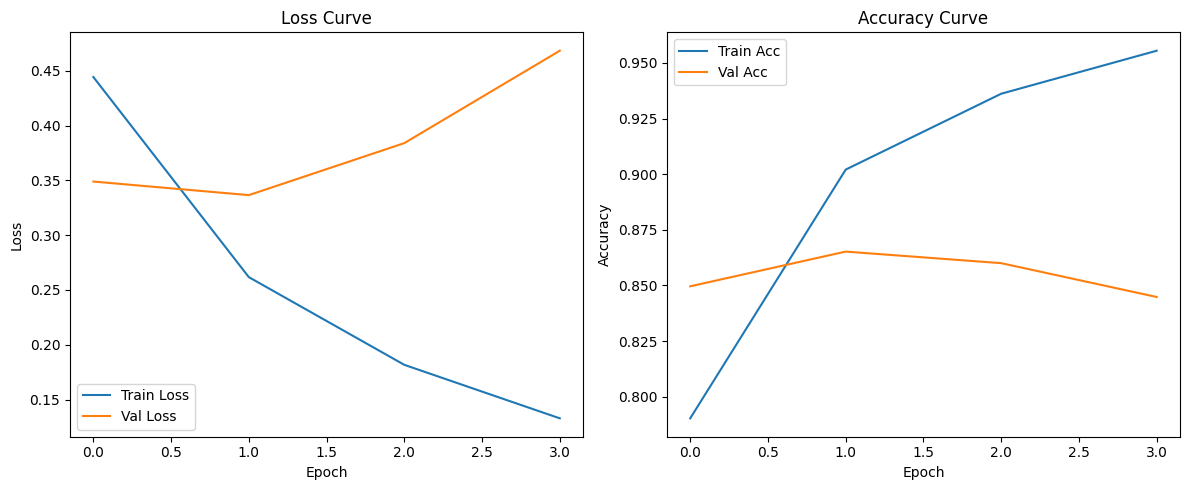

In [24]:
# Plot training and validation loss and accuracy curves after Hyperparameter tuning
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate the model on the test set and compute accuracy, precision, recall, and F1-score
y_pred_prob = model.predict(X_test)
y_pred_idx = y_pred_prob.argmax(axis=1)
acc = accuracy_score(y_test, y_pred_idx)
prec = precision_score(y_test, y_pred_idx, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred_idx, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_idx, average='weighted', zero_division=0)

782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step


In [27]:
# Show accuracy, precision, recall, and F1-score
print(f'Accuracy  : {acc:.4f}')
print(f'Precision : {prec:.4f}')
print(f'Recall    : {rec:.4f}')
print(f'F1-score  : {f1:.4f}')

Accuracy  : 0.8358
Precision : 0.8360
Recall    : 0.8358
F1-score  : 0.8358


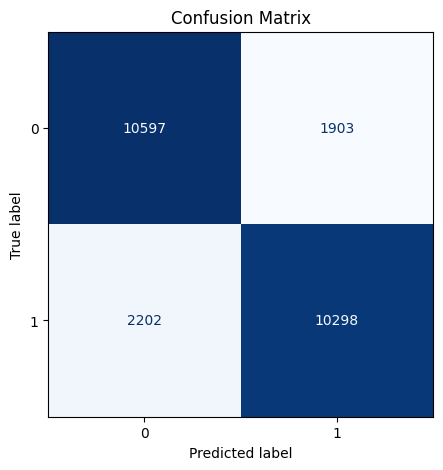

In [38]:
# Visualize the confusion matrix for the LSTM model's predictions
cm = confusion_matrix(y_test, y_pred_idx)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained LSTM model to the Files directory
os.makedirs('Files', exist_ok=True)
model.save(os.path.join('Files', 'lstm_model.h5'))

In [16]:
# Save the tokenizer and label encoder for future predictions
os.makedirs('Files', exist_ok=True)
joblib.dump(tokenizer, os.path.join('Files', 'tokenizer.joblib'))
joblib.dump(le, os.path.join('Files', 'encoder.joblib'))
'Tokenizer and label encoder saved successfully.'

'Tokenizer and label encoder saved successfully.'

In [17]:
# Load saved model, tokenizer, and encoder, then run an interactive prediction
model = tf.keras.models.load_model(os.path.join('Files', 'lstm_model.h5'))
tokenizer = joblib.load(os.path.join('Files', 'tokenizer.joblib'))
le = joblib.load(os.path.join('Files', 'encoder.joblib'))

def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=200, padding='post', truncating='post')
    pred_idx = np.argmax(model.predict(padded), axis=1)[0]
    label = le.classes_[pred_idx]
    if str(label) == '1':
        return 'Positive'
    elif str(label) == '0':
        return 'Negative'
    else:
        return label

user_input = input('Enter a sentence: ')
print(f"Input: {user_input}")
print('Predicted sentiment:', predict_sentiment(user_input))

Input: The pacing dragged endlessly, the plot was full of holes, and the characters were so underdeveloped that I couldn’t care less what happened to them. The dialogue felt forced and cringe-worthy, and even the usually reliable seemed bored in their role.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted sentiment: Negative
